<a href="https://colab.research.google.com/github/fobembe/Economic-Freedom/blob/master/Stock_price_Predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Import libraries
import math
import pandas_datareader as web
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

/usr/local/lib/python3.6/dist-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal
Using TensorFlow backend.


In [2]:
#Get the stock quote for Apple
df = web.DataReader('AAPL',data_source='yahoo',start='2012-01-01',end='2019-12-17')
df.head(10)

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2012-01-03,58.928570,58.428570,58.485714,58.747143,75555200.0,50.857235
2012-01-04,59.240002,58.468571,58.571430,59.062859,65005500.0,51.130558
2012-01-05,59.792858,58.952858,59.278572,59.718571,67817400.0,51.698215
2012-01-06,60.392857,59.888573,59.967144,60.342857,79573200.0,52.238651
2012-01-09,61.107143,60.192856,60.785713,60.247143,98506100.0,52.155792
2012-01-10,60.857143,60.214287,60.844284,60.462856,64549100.0,52.342537
2012-01-11,60.407143,59.901428,60.382858,60.364285,53771200.0,52.257195
2012-01-12,60.414288,59.821430,60.325714,60.198570,53146800.0,52.113747
2012-01-13,60.064285,59.808571,59.957142,59.972858,56505400.0,51.918343


In [3]:
df.shape

(2003, 6)

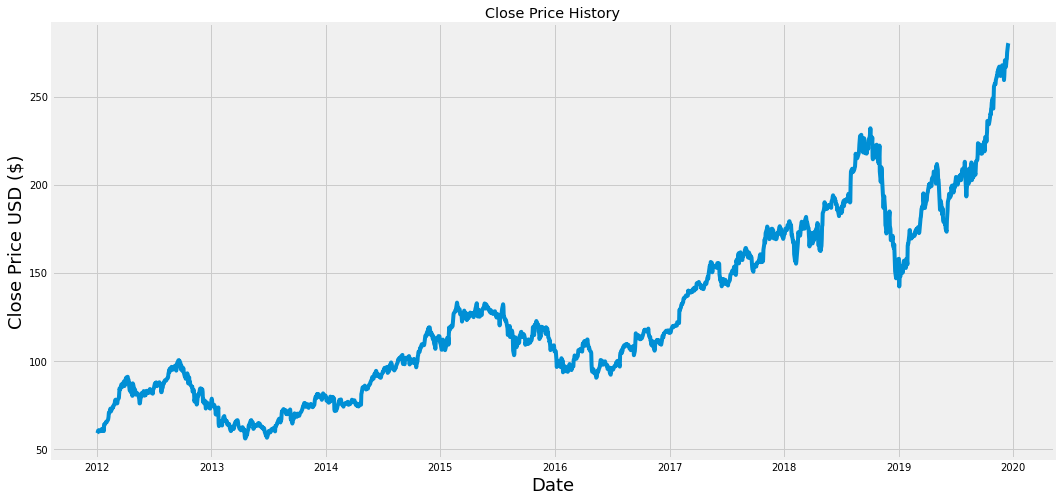

In [7]:
#Create a graph to visualize the data
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price USD ($)',fontsize=18)
plt.show()

In [8]:
#Create a new dataframe with only the 'Close' column
data = df.filter(['Close'])
data.head()

,Close
Date,
2012-01-03,58.747143
2012-01-04,59.062859
2012-01-05,59.718571
2012-01-06,60.342857
2012-01-09,60.247143


In [9]:
#Convert the dataframe to a numpy array
dataset = data.values

In [10]:
#Get/compute the number of rows to train the model on
training_data_len = math.ceil(len(dataset)*.8)

In [11]:
#scale the dataset to 0 and 1
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

In [13]:
#Create the scaled training data set
train_data = scaled_data[0:training_data_len,:]

In [14]:
#Split the data into X_train and y_train data sets
X_train = []
y_train = []
for i in range(60,len(train_data)):
  X_train.append(train_data[i-60:i,0])
  y_train.append(train_data[i,0])

In [15]:
#Convert X_train and y_train to numpy arrays
X_train,y_train = np.array(X_train),np.array(y_train)

In [16]:
#Reshape the data into teh shape accepted by the LSTM
X_train = np.reshape(X_train,(X_train.shape[0],X_train.shape[1],1))

In [17]:
#Build the LSTM network model
model = Sequential()
model.add(LSTM(units=50,return_sequences=True,input_shape=(X_train.shape[1],1)))
model.add(LSTM(units=50,return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))

In [19]:
#Compile the model
model.compile(optimizer='adam',loss='mean_squared_error')

In [20]:
#Train the model
model.fit(X_train,y_train,batch_size=1,epochs=1)

Epoch 1/1
1543/1543 [==============================] - 60s 39ms/step - loss: 8.6370e-04


In [21]:
#Create a test data set
test_data = scaled_data[training_data_len - 60:,:]

In [22]:
#Create the X_test and y_test data sets
X_test = []
y_test = dataset[training_data_len:,:]  #Get all of the rows from index 1603 to teh rest and all of the columns (i.e. Close) which is 2003-1602 = 400 rows
for i in range(60,len(test_data)):
  X_test.append(test_data[i-60:i,0])


In [23]:
#convert the X_test to a numpy array
X_test = np.array(X_test)

In [25]:
#Reshape the data into the shape accepted by the LSTM
X_test = np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))

In [26]:
#Get the predicted values from the model
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions) #undo scaling

In [27]:
#Calculate RMSE:  The closer the value of RMSE to 0, the better the predictions
rmse = np.sqrt(np.mean(((predictions-y_test)**2)))

In [28]:
rmse

9.909303232996663

In [29]:
#visualize the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions']=predictions

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


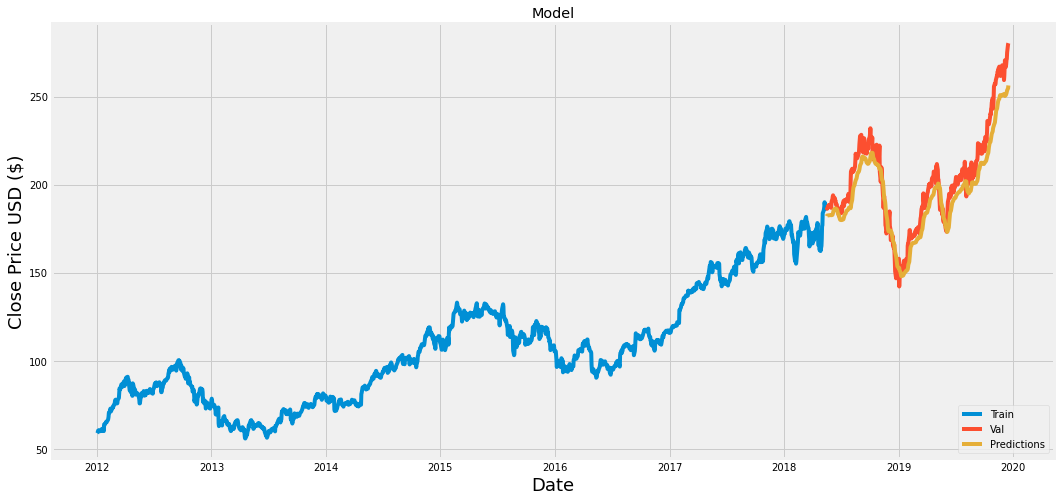

In [30]:
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price USD ($)',fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])
plt.legend(['Train','Val','Predictions'],loc='lower right')
plt.show()

In [31]:
#Show the valid and predicted prices
valid

,Close,Predictions
Date,,
2018-05-17,186.990005,182.115311
2018-05-18,186.309998,182.482422
2018-05-21,187.630005,182.565491
2018-05-22,187.160004,182.608490
2018-05-23,188.360001,182.574753
...,...,...
2019-12-11,270.769989,252.031052
2019-12-12,271.459991,252.796524
2019-12-13,275.149994,253.640610


In [32]:
#Perform a test on the data by getting the price for December 18, 2019
#Get the Quote
apple_quote = web.DataReader('AAPL',data_source='yahoo',start='2012-01-01',end='2019-12-17')

In [33]:
#Create a new dataframe
new_df = apple_quote.filter(['Close'])

In [34]:
#Get the last 60 day closing price
last_60_days = new_df[-60:].values

In [37]:
#scale the data to be values between 0 and 1
last_60_days_scaled = scaler.transform(last_60_days)

In [38]:
#Create an empty list
X_test = []

In [39]:
#Append the past 60 days
X_test.append(last_60_days_scaled)

In [40]:
#Convert teh X_test data set to a numpy array
X_test = np.array(X_test)

In [41]:
#Reshape the data
X_test = np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))

In [42]:
#Get the predicted scaled price
pred_price = model.predict(X_test)

In [43]:
#Undo the scaling
pred_price = scaler.inverse_transform(pred_price)
print(pred_price)

[[0.43843114]]


In [44]:
#Lets see the actual price
apple_quote2 = web.DataReader('AAPL',data_source='yahoo',start='2019-12-18',end='2019-12-18')
print(apple_quote2['Close'])

Date
2019-12-18    279.73999
Name: Close, dtype: float64
